# HW5-Lab1 - 微调BERT预训练模型 - Math Word Problem

## 1. 数据集准备

我们仍然使用 [Math23K](https://paperswithcode.com/dataset/math23k) 数据集。

In [1]:
import json
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seed.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [2]:
def read_math23k_data(path):
    """读取 Math23K 数据集。"""
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    problems = [item["text"].replace(" ", "") for item in data]
    equations = [item["target_template"][2:] for item in data]  # 移除方程的 'x=' 前缀
    return problems, equations


# 加载训练集和测试集
train_path, test_path = "data/train.json", "data/test.json"
train_problems, train_equations = read_math23k_data(train_path)
test_problems, test_equations = read_math23k_data(test_path)

print(f"训练集大小: {len(train_problems)}")
print(f"测试集大小: {len(test_problems)}")

# 打印一些示例数据
for i in range(3):
    print(f"问题 {i+1}: {train_problems[i]}")
    print(f"方程 {i+1}: {train_equations[i]}")
    print("-" * 20)

训练集大小: 22162
测试集大小: 1000
问题 1: 甲数除以乙数的商是temp_a，如果甲数增加temp_b，则甲数是乙的temp_c倍．原来甲数=．
方程 1: ['temp_b', '/', '(', 'temp_c', '-', 'temp_a', ')', '*', 'temp_a']
--------------------
问题 2: 客车和货车分别从A、B两站同时相向开出，temp_a小时后相遇．相遇后，两车仍按原速度前进，当它们相距temp_b千米时，货车行了全程的temp_c%，客车已行的路程与未行的路程比是temp_d：temp_e．求A、B两站间的路程．
方程 2: ['temp_b', '/', '(', 'temp_c', '+', '(', '(', 'temp_d', ')', '/', '(', 'temp_d', '+', 'temp_e', ')', ')', '-', '1', ')']
--------------------
问题 3: 图书角有书temp_a本，第一天借出了temp_b，第二天又还回temp_c本，现在图书角有多少本书？
方程 3: ['temp_a', '*', '(', '1', '-', 'temp_b', ')', '+', 'temp_c']
--------------------


## 2. 数据预处理

在将数据输入 BERT 模型之前，我们需要对数据进行预处理，这包括：
- 不同于之前，我们这里使用 BERT 的 tokenizer 对 problems 进行编码
- 对于 equations 的编码和之前一样

### 2.1 使用 BERT Tokenizer

In [3]:
from transformers import BertTokenizer

# 使用 bert-base-chinese 预训练模型
src_tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")


def preprocess_src_sentence(sentence, tokenizer, max_len):
    inputs = tokenizer(
        sentence,
        add_special_tokens=True,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_len,
    )
    return inputs["input_ids"].squeeze()


out = preprocess_src_sentence(train_problems[0], src_tokenizer, 60)
print(out)
print(src_tokenizer.decode(out))

tensor([ 101, 4508, 3144, 7370,  809,  734, 3144, 4638, 1555, 3221, 8282, 9085,
         142,  143, 8024, 1963, 3362, 4508, 3144, 1872, 1217, 8282, 9085,  142,
         144, 8024, 1156, 4508, 3144, 3221,  734, 4638, 8282, 9085,  142,  145,
         945, 8026, 1333, 3341, 4508, 3144,  134, 8026,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])
[CLS] 甲 数 除 以 乙 数 的 商 是 temp _ a ， 如 果 甲 数 增 加 temp _ b ， 则 甲 数 是 乙 的 temp _ c 倍 ． 原 来 甲 数 = ． [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


这段代码展示了如何使用预训练的 bert-base-chinese 模型的 tokenizer 对问题进行编码。preprocess_src_sentence 函数接收一个句子、tokenizer 和最大长度作为输入，并将句子转换为 BERT 模型可以理解的数字表示。

### 2.2 对 equations 进行编码

In [4]:
from collections import Counter


class Vocab:
    def __init__(self, sentence_list, min_count=1):
        self.token2idx = {"<unk>": 0, "<pad>": 1, "<bos>": 2, "<eos>": 3}
        self.build_vocab(sentence_list, min_count)

    def build_vocab(self, sentence_list, min_count):
        token_counts = Counter([token for sentence in sentence_list for token in sentence])
        sorted_tokens = [token for token, count in token_counts.items() if count >= min_count]
        sorted_tokens.sort(key=lambda token: token_counts[token], reverse=True)
        for token in sorted_tokens:
            self.token2idx[token] = len(self.token2idx)
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}

    def __len__(self):
        return len(self.idx2token)

    def token_to_index(self, token):
        return self.token2idx.get(token, self.token2idx["<unk>"])

    def index_to_token(self, index):
        return self.idx2token.get(index, "<unk>")

    def to_tokens(self, indices):
        return [self.index_to_token(index) for index in indices]

    def to_indices(self, tokens):
        return [self.token_to_index(token) for token in tokens]

    def __repr__(self):
        return f"Vocab(size={len(self)})"

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_index(tokens)
        return [self.token_to_index(token) for token in tokens]


def preprocess_tgt_sentence(sentence, vocab, max_len):
    sentence = ["<bos>"] + sentence + ["<eos>"]
    indices = vocab[sentence]
    indices = torch.tensor(indices)
    if len(indices) > max_len:
        indices = indices[:max_len]
    else:
        pad_size = max_len - len(indices)
        indices = F.pad(indices, (0, pad_size), value=vocab["<pad>"])
    return indices


tgt_vocab = Vocab(train_equations + test_equations)
print(f"Target Vocab Size: {len(tgt_vocab)}")

out = preprocess_tgt_sentence(train_equations[0], tgt_vocab, 50)
print(out)
print(" ".join(tgt_vocab.to_tokens(out.tolist())))

Target Vocab Size: 30
tensor([ 2,  5,  6,  7, 10, 11,  4,  8,  9,  4,  3,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])
<bos> temp_b / ( temp_c - temp_a ) * temp_a <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


### 2.3 创建数据集

In [5]:
class Math23kDataset(Dataset):
    def __init__(self, problems, equations, src_tokenizer, tgt_vocab, src_max_len=120, tgt_max_len=50):
        self.src_data = [preprocess_src_sentence(sentence, src_tokenizer, src_max_len) for sentence in problems]
        self.tgt_data = [preprocess_tgt_sentence(sentence, tgt_vocab, tgt_max_len) for sentence in equations]

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        return self.src_data[idx], self.tgt_data[idx]


# 创建数据集
train_dataset = Math23kDataset(train_problems, train_equations, src_tokenizer, tgt_vocab)
test_dataset = Math23kDataset(test_problems, test_equations, src_tokenizer, tgt_vocab)

## 3. 构建模型

这里我们定义一个 BertSeq2SeqTransformer 模型，它使用预训练的 BERT 模型作为编码器，并使用 Transformer 解码器生成公式，其中 BERT 模型的权重固定，不参与训练。

In [6]:
import torch.nn as nn
import math


class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer("pos_embedding", pos_embedding)

    def forward(self, token_embedding: torch.Tensor):
        return self.dropout(token_embedding + self.pos_embedding[: token_embedding.size(1), :])


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: torch.Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [7]:
from transformers import BertModel


class BertSeq2SeqTransformer(nn.Module):
    def __init__(
        self, num_decoder_layers: int, emb_size, nhead, tgt_vocab_size, dim_feedforward: int = 512, dropout: float = 0.1
    ):
        super(BertSeq2SeqTransformer, self).__init__()

        # 使用预训练的 BERT 模型作为编码器
        self.bert = BertModel.from_pretrained("bert-base-chinese")
        # 冻结BERT模型的参数，使其在训练过程中不被更新
        for param in self.bert.parameters():
            param.requires_grad = False
        self.bert_output_linear = nn.Linear(768, emb_size)

        # 解码器部分
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=emb_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(
        self,
        src: torch.Tensor,
        trg: torch.Tensor,
        src_mask: torch.Tensor,
        tgt_mask: torch.Tensor,
        src_padding_mask: torch.Tensor,
        tgt_padding_mask: torch.Tensor,
    ):
        # TODO: 实现模型的前向传播
        memory = self.encode(src, src_mask, src_padding_mask)
        output = self.decode(trg, memory, tgt_mask)
        return self.generator(output)

    def encode(self, src: torch.Tensor, src_mask: torch.Tensor, src_key_padding_mask=None):
        with torch.no_grad():
            src_emb = self.bert(src, attention_mask=~src_key_padding_mask)[0]
        src_emb = self.bert_output_linear(src_emb)
        return src_emb

    def decode(self, tgt: torch.Tensor, memory: torch.Tensor, tgt_mask: torch.Tensor):
        return self.transformer_decoder(self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask)

## 4. 训练模型

### 4.1 定义训练函数和评估函数

In [8]:
SRC_PAD_IDX, TGT_PAD_IDX = 0, 1


def create_mask(src, tgt):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    src_mask = torch.zeros((src_seq_len, src_seq_len), dtype=torch.bool, device=DEVICE)
    tgt_mask = torch.ones((tgt_seq_len, tgt_seq_len), dtype=torch.bool, device=DEVICE).triu_(diagonal=1)

    src_padding_mask = src == SRC_PAD_IDX
    tgt_padding_mask = tgt == TGT_PAD_IDX
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [9]:
def train_epoch(model, train_loader, optimizer, loss_fn):
    model.train()
    losses = 0
    for src, tgt in train_loader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        tgt_input = tgt[:, :-1]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
        optimizer.zero_grad()

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()
        losses += loss.item()

    return losses / len(train_loader)


def evaluate(model, val_loader, loss_fn):
    model.eval()
    losses = 0
    for src, tgt in val_loader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        tgt_input = tgt[:, :-1]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_loader)

### 4.2 设置超参数和初始化模型

In [10]:
TGT_VOCAB_SIZE = len(tgt_vocab)
EMB_SIZE = 128
NHEAD = 8  # 注意力头数
FFN_HID_DIM = 512  # FeedForward隐藏层维度
NUM_LAYERS = 4  # Transformer层数

BATCH_SIZE = 64
LEARNING_RATE = 0.0008
DROP_OUT = 0.1

model = BertSeq2SeqTransformer(NUM_LAYERS, EMB_SIZE, NHEAD, TGT_VOCAB_SIZE, FFN_HID_DIM, DROP_OUT)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable params:", total_params / 1e6, "M")

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab["<pad>"])
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Total trainable params: 1.164446 M


### 4.3 开始训练

In [11]:
from timeit import default_timer as timer

from torch.utils.data import DataLoader

NUM_EPOCHS = 30

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

train_loss_list, valid_loss_list = [], []

for epoch in range(NUM_EPOCHS):
    start_time = timer()
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)
    end_time = timer()
    train_loss_list.append(train_loss)
    valid_loss_list.append(val_loss)
    print(
        (
            f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "
            f"Epoch time = {(end_time - start_time):.3f}s"
        )
    )

# 保存模型
torch.save(model.state_dict(), "bert_model.pth")

Epoch: 0, Train loss: 0.998, Val loss: 0.743, Epoch time = 62.231s
Epoch: 1, Train loss: 0.699, Val loss: 0.614, Epoch time = 62.369s
Epoch: 2, Train loss: 0.598, Val loss: 0.528, Epoch time = 62.368s
Epoch: 3, Train loss: 0.536, Val loss: 0.502, Epoch time = 62.381s
Epoch: 4, Train loss: 0.496, Val loss: 0.484, Epoch time = 62.393s
Epoch: 5, Train loss: 0.464, Val loss: 0.446, Epoch time = 62.406s
Epoch: 6, Train loss: 0.439, Val loss: 0.436, Epoch time = 62.408s
Epoch: 7, Train loss: 0.422, Val loss: 0.417, Epoch time = 62.404s
Epoch: 8, Train loss: 0.402, Val loss: 0.400, Epoch time = 62.408s
Epoch: 9, Train loss: 0.391, Val loss: 0.400, Epoch time = 62.407s
Epoch: 10, Train loss: 0.376, Val loss: 0.400, Epoch time = 62.408s
Epoch: 11, Train loss: 0.363, Val loss: 0.379, Epoch time = 62.415s
Epoch: 12, Train loss: 0.352, Val loss: 0.383, Epoch time = 62.425s
Epoch: 13, Train loss: 0.344, Val loss: 0.384, Epoch time = 62.417s
Epoch: 14, Train loss: 0.338, Val loss: 0.369, Epoch time 

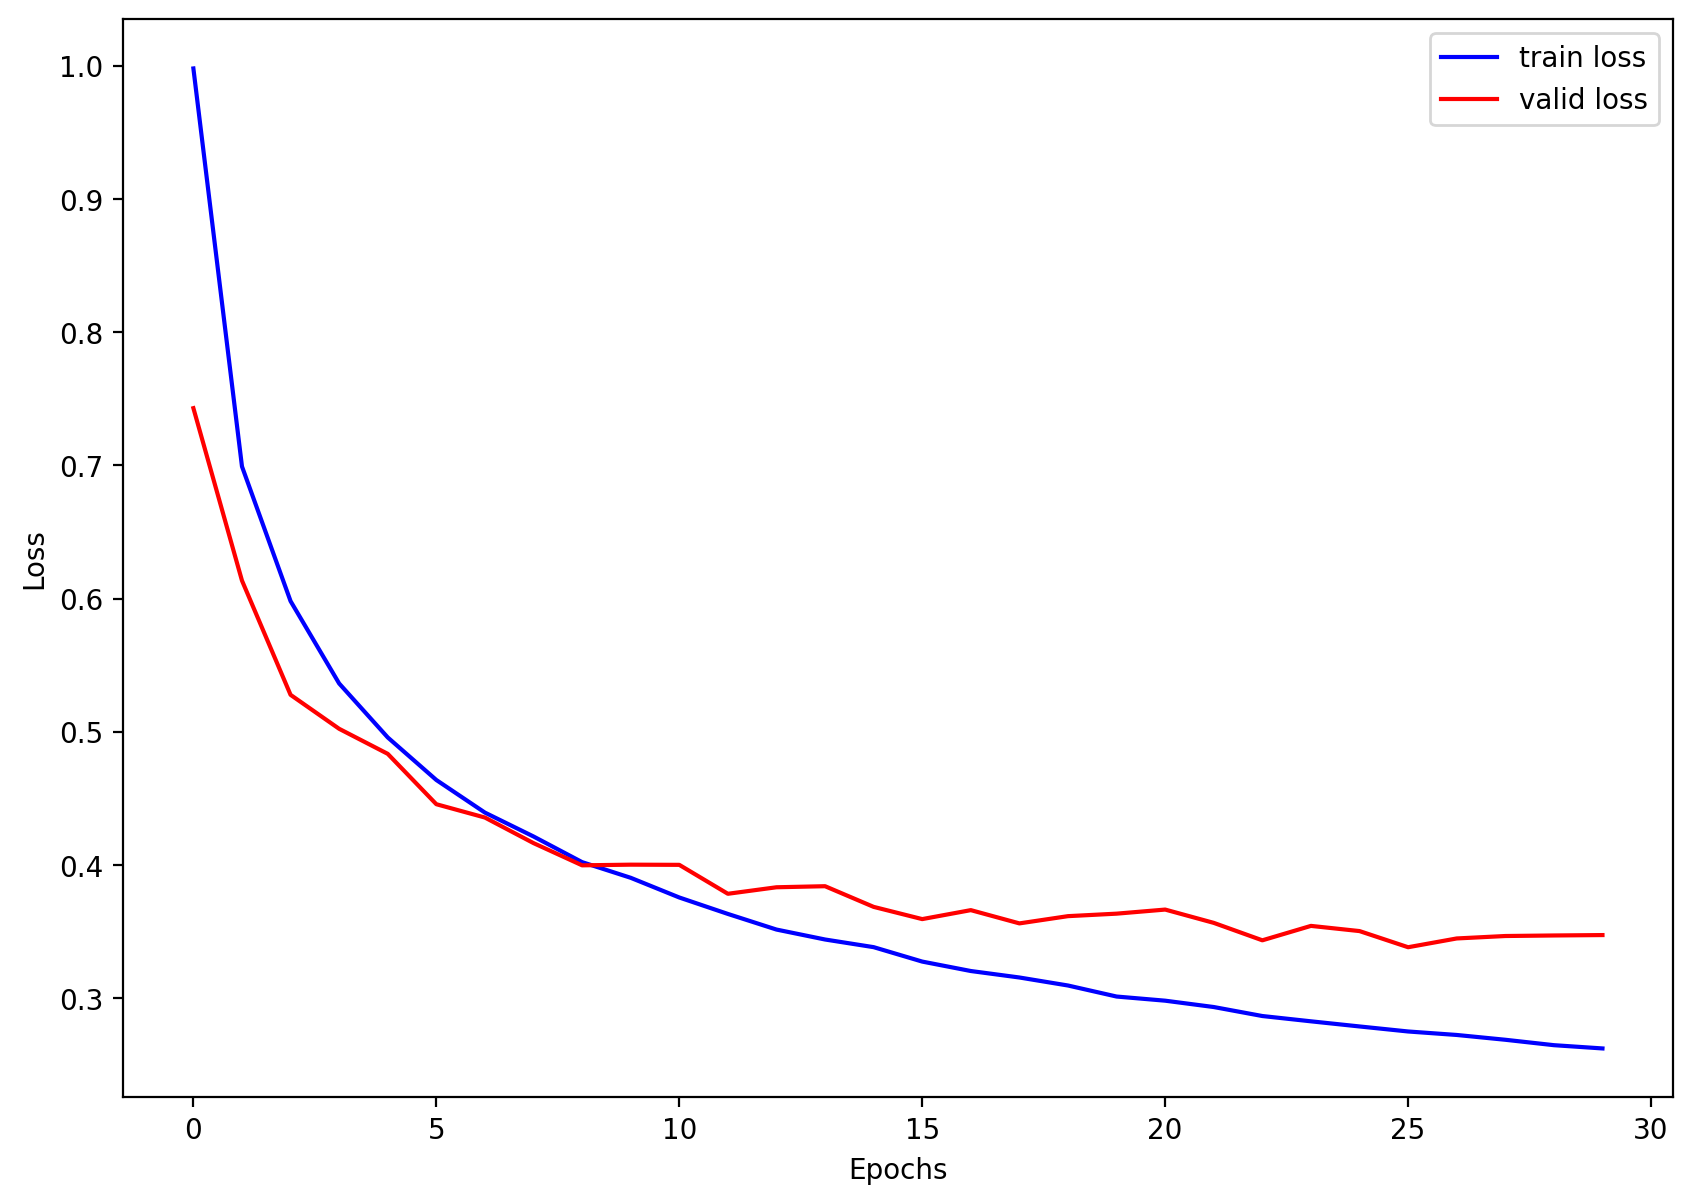

In [12]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'
plt.figure(figsize=(10, 7))
plt.plot(train_loss_list, color="blue", linestyle="-", label="train loss")
plt.plot(valid_loss_list, color="red", linestyle="-", label="valid loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 5. 模型评估

In [13]:
def equation_accuracy(preds, tgts):
    correct = 0
    for tgt, pred in zip(tgts, preds):
        if tgt == pred:
            correct += 1
    return correct / len(tgts)


@torch.no_grad()
def greedy_decode(model, src, max_len, start_symbol):
    src = src.to(DEVICE)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    src_mask, tgt_mask, src_padding_mask, _ = create_mask(src, ys)

    memory = model.encode(src, src_mask, src_padding_mask)

    for i in range(max_len - 1):
        tgt_mask = torch.ones((ys.shape[1], ys.shape[1]), dtype=torch.bool, device=DEVICE).triu_(diagonal=1)

        out = model.decode(ys, memory, tgt_mask)

        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type(torch.long).to(DEVICE)], dim=1)
        if next_word == tgt_vocab["<eos>"]:
            break
    return ys


@torch.no_grad()
def inference(model, problem):
    model.eval()
    src = preprocess_src_sentence(problem, src_tokenizer, 120)
    src = src.unsqueeze(0)
    tgt_tokens = greedy_decode(model, src, max_len=50, start_symbol=tgt_vocab["<bos>"]).flatten()
    return "".join(tgt_vocab.to_tokens(tgt_tokens.tolist())).replace("<bos>", "").replace("<eos>", "")

In [14]:
for i in range(5):
    problem, equation = test_problems[i], test_equations[i]
    print(f"问题 {i+1}: {problem}")
    print(f"真实方程: {''.join(equation)}")
    print(f"预测方程: {inference(model, problem)}")
    print("-" * 20)

问题 1: 在一正方形花池的四周栽了temp_a棵柳树，每两棵柳树之间的间隔是temp_b米，这个正方形的周长=多少米？
真实方程: temp_a*temp_b
预测方程: temp_b*(temp_a-1)
--------------------
问题 2: 张明有temp_a元钱，买书用去temp_b%，买文具的钱是买书的temp_c%．买文具用去多少元？
真实方程: temp_a*temp_b*temp_c
预测方程: temp_a*temp_b/temp_c
--------------------
问题 3: 一个工厂要生产temp_a个零件，前temp_b天生产了temp_c个，剩下的要在temp_d天内完成，平均每天生产多少个？
真实方程: (temp_a-temp_c)/temp_d
预测方程: (temp_a-temp_c)/temp_d
--------------------
问题 4: 一本字典定价temp_a元，temp_b出售后还赚temp_c%，这本字典进价=多少元．
真实方程: temp_a*temp_b/(1+temp_c)
预测方程: temp_a*temp_b/(1+temp_c)
--------------------
问题 5: 修一段长temp_a米的路，前temp_b小时共修了temp_c米，剩下的每小时修temp_d米，还要几小时才能修完？
真实方程: (temp_a-temp_c)/temp_d
预测方程: (temp_a-temp_c)/temp_d
--------------------


In [15]:
from tqdm import tqdm

test_loader = DataLoader(test_dataset, batch_size=1)
preds, tgts = [], []
for src, tgt in tqdm(test_loader):
    pred = greedy_decode(model, src, max_len=50, start_symbol=tgt_vocab["<bos>"]).flatten()
    pred = tgt_vocab.to_tokens(pred.tolist())
    preds.append("".join(pred).replace("<bos>", "").replace("<eos>", "").replace("<pad>", ""))
    tgts.append(
        "".join(tgt_vocab.to_tokens(tgt[0].tolist())).replace("<bos>", "").replace("<eos>", "").replace("<pad>", "")
    )
acc = equation_accuracy(preds, tgts)

100%|██████████| 1000/1000 [00:13<00:00, 75.89it/s]


In [16]:
print(f"方程准确率: {acc:.3f}")

方程准确率: 0.571
